In [1]:
import math 
import string 
import re

import json 

import pandas as pd 
import sqlite3
import spacy
import numpy as np
nlp = spacy.load('en_core_web_sm')

In [2]:
qualified_annotators_dict = {'pubmed': ['ann_jclvzw', 'ann_eftpco'],
                            'news': ['ann_japq', 'ann_tpfo'],
                            'billsum': ['ann_krcnbm', 'ann_hguilf']}


def connect_to_db(db_path):
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    return conn, c 

def read_annotations(db_path, task):
    # /human_annotations_factuality/XSUM_CNN
    parent_path = '/home/ramprasad.sa'
    db_path_round1 = f'{parent_path}/{db_path}/set1/annotated/{task}_summaries_set1_final.db'
    print(db_path_round1)
    conn, c = connect_to_db(db_path_round1)
    df_annotations_round1  = pd.read_sql('SELECT * from label', conn)

    db_path_round2 = f'{parent_path}/{db_path}/set1_round2/annotated/{task}_nonfactual_annotated_generated_summaries_fin.db'
    conn, c = connect_to_db(db_path_round2)
    df_annotations_round2 = pd.read_sql('SELECT * from error_label', conn)
    return df_annotations_round1, df_annotations_round2
    
    
def remove_duplicates(df, task):
    
    qualified_annotators_dict = {'pubmed': ['ann_jclvzw', 'ann_eftpco'],
                            'news': ['ann_japq', 'ann_tpfo'],
                            'billsum': ['ann_krcnbm', 'ann_hguilf']}
    qualified_annotators = qualified_annotators_dict[task]
    processed_rows = []
    
    for annotator in qualified_annotators:
        df_qualified_annotators = df[df['user_id'] == annotator]
        # print(df_qualified_annotators)
        for each_id in list(set(df_qualified_annotators['summary_uuid'].values)):
            df_uid = df_qualified_annotators[df_qualified_annotators['summary_uuid'] == each_id]
            if len(df_uid) == 1:
                row_append = df_uid.iloc[[0]]
            else:
                row_append = df_uid.iloc[[-1]]
            processed_rows.append(row_append)
            
    df_processed = pd.concat(processed_rows)
    return df_processed

def make_pids(df_annotations):
    pids = []
    for idx, row in df_annotations.iterrows():
        summary_uuid = row['summary_uuid'].split('_ann_')[0].strip()
        pids.append(summary_uuid)
    df_annotations['pid'] = pids
    return df_annotations

def refine_df(df_annotations, task):
    
    df_annotations = remove_duplicates(df_annotations, task)
    df_annotations = make_pids(df_annotations)
    return df_annotations

def test_annotation_rounds(df_annotations_round1, df_annotations_round2, task):
    
    
    for qual_ann in qualified_annotators_dict[task]:
        df_ann_r1 = df_annotations_round1[df_annotations_round1['user_id'] == qual_ann]
        df_ann_r1_sents = df_ann_r1[df_ann_r1['label_type'] == 'non_factual']['nonfactual_sentences'].values
        df_ann_r1_sents = [len(each.split('<new_annotation>')) for each in df_ann_r1_sents ]
        
        df_ann_r2 = df_annotations_round2[df_annotations_round2['user_id'] == qual_ann]
        assert sum(df_ann_r1_sents) ==  len(df_ann_r2)
    return



def make_sentence_error_maps(task_annotators,  df_round2_article_summ):
    sentence_error_category_map = {}
    if not len(df_round2_article_summ):
            sentence_error_category_map[None] = {0: (None, None, None, None), 1: (None, None, None, None)}
            
    else:
        for annotator in task_annotators:
            df_round2_article_summ_annotator = df_round2_article_summ[df_round2_article_summ['user_id'] == annotator]
            for error_idx, error_row in df_round2_article_summ_annotator.iterrows():
                    user_id = task_annotators.index(error_row['user_id'])
                    nonfactual_sentence = error_row['nonfactual_sentence']
                    inaccuracy_severity = error_row['inaccuracy_severity']
                    error_type = error_row['error_type']
                    error_factuality = error_row['error_factuality'] 
                    error_factuality = error_factuality if error_factuality else None
                    comments = error_row['comments']
                    comments = comments if comments else None

                    if nonfactual_sentence not in sentence_error_category_map:
                        sentence_error_category_map[nonfactual_sentence] = {0: (None, None, None, None), 1: (None, None, None, None)}
                    sentence_error_category_map[nonfactual_sentence][user_id] = (inaccuracy_severity, error_type, error_factuality, comments)
    return sentence_error_category_map
    


def rectified_annotations(df_aggr, ann_idx):
    
    label_types_ann = list(df_aggr[f'label_type_ann{ann_idx}'].values)
    inaccuracy_severity_ann = list(df_aggr[f'inaccuracy_severity_ann{ann_idx}'].values)
    error_type_ann = list(df_aggr[f'error_type_ann{ann_idx}'].values)
    error_factuality_ann = list(df_aggr[f'error_factuality_ann{ann_idx}'].values)
    
    for idx, row in df_aggr.iterrows():
        comment = row[f'comments_ann{ann_idx}']
        error_type = row[f'error_type_ann{ann_idx}']
        if comment != None :
            comment = comment.lower()
            if 'accurate' in comment or 'factual' in comment or 'this is correct' in comment:
                # print(comment, idx, label_types_ann[idx])
                label_types_ann[idx] =  'factual'
                # print(label_types_ann[idx])
                inaccuracy_severity_ann[idx] = None
                error_type_ann[idx] = None
                error_factuality_ann[idx] = None
                
    df_aggr[f'label_type_ann{ann_idx}'] = label_types_ann
    df_aggr[f'inaccuracy_severity_ann{ann_idx}'] = inaccuracy_severity_ann
    df_aggr[f'error_type_ann{ann_idx}'] = error_type_ann
    df_aggr[f'error_factuality_ann{ann_idx}'] = error_factuality_ann
    return df_aggr

def make_aggr_df(df_annotations_round1, df_annotations_round2, task):
    
    df_processed_dict = {
    'summary_uuid': [],
    'pid': [],
    'summary': [],
    'article': [],
    'summ_id': [],
    'system_id': [],
    'nonfactual_sentence': [],
    'label_type_ann1': [],
    'label_type_ann2': [],
    'inaccuracy_severity_ann1': [],
    'inaccuracy_severity_ann2': [],
    'error_type_ann1': [],
    'error_type_ann2': [],  
    'error_factuality_ann1': [],
    'error_factuality_ann2': [],
    'comments_ann1': [],
    'comments_ann2': [],

    }
    
    unique_articles = list(set(df_annotations_round1['article'].values))
    task_annotators = qualified_annotators_dict[task]

    for article in unique_articles:
        df_round1_article = df_annotations_round1[df_annotations_round1['article'] == article]
        df_round2_article = df_annotations_round2[df_annotations_round2['article'] == article]

        article_summaries = list(set(df_round1_article['summary'].values))

        for article_summary in article_summaries:

            df_round1_article_summ = df_round1_article[df_round1_article['summary'] == article_summary]
            df_round2_article_summ = df_round2_article[df_round2_article['summary'] == article_summary]
            if len(df_round1_article_summ) <2 :
                print(article_summary)
            else:
                label_type_annotations = []
                for annotator in task_annotators:
                    df_round1_article_summ_annotator = df_round1_article_summ[df_round1_article_summ['user_id'] == annotator]

                    label_type_annotations.append(df_round1_article_summ_annotator['label_type'].values[0])

                sentence_error_category_map = make_sentence_error_maps(task_annotators,  df_round2_article_summ)



                for nonfactual_sentence, nonfactual_sentence_annotations in sentence_error_category_map.items():
                    summary_uuid = df_round1_article_summ['summary_uuid'].values[0]
                    summ_id = df_round1_article_summ['summ_id'].values[0]
                    system_id = df_round1_article_summ['system_id'].values[0]
                    pid = list(set(df_round2_article_summ['pid'].values))
                    summary = df_round1_article_summ['summary'].values[0]

                    df_processed_dict['summary_uuid'].append(summary_uuid)
                    df_processed_dict['summ_id'].append(summ_id)
                    df_processed_dict['system_id'].append(system_id)
                    df_processed_dict['pid'].append(pid)
                    # df_processed_dict['pid_2'].append(pid)
                    df_processed_dict['summary'].append(summary)
                    df_processed_dict['article'].append(article)

                    df_processed_dict['nonfactual_sentence'].append(nonfactual_sentence)
                    for lid, label_annotations in enumerate(label_type_annotations):
                        df_processed_dict[f'label_type_ann{lid+1}'] += [label_annotations]

                    # ann_vals = {
                    for ann_id, ann_vals in nonfactual_sentence_annotations.items():
                        ann_id = ann_id + 1
                        df_processed_dict[f'inaccuracy_severity_ann{ann_id}'].append(ann_vals[0])
                        df_processed_dict[f'error_type_ann{ann_id}'].append(ann_vals[1])
                        df_processed_dict[f'error_factuality_ann{ann_id}'].append(ann_vals[2])
                        df_processed_dict[f'comments_ann{ann_id}'].append(ann_vals[3])
                        
    return pd.DataFrame(df_processed_dict)

            
    


def compute_score(df_aggr, task):

    unique_ids = list(set(df_aggr['summary_uuid']))
    df_errors_scores = {'summary_uuid': [], 'score': [], 'model': [], 'task': [], 'summary': [], 'article': []}
    for model in ['flant5', 'gpt3']:
        df_model = df_aggr[df_aggr['system_id'] == model]
        unique_ids = list(set(df_model['summary_uuid']))
        print(len(unique_ids))
        model_sentbased_scores = []
        for uuid in unique_ids:

            df_uuid = df_aggr[df_aggr['summary_uuid'] == uuid]
            # print(df_uuid)
            summary = df_uuid['summary'].values[0]
            summ_sents =  list(nlp(summary).sents)
            ann1_scores = []
            ann2_scores = []
            for idx, row in df_uuid.iterrows():
                nonfactual_sentence = row['nonfactual_sentence']
                label_type_ann1 = row['inaccuracy_severity_ann1']
                label_type_ann2 = row['inaccuracy_severity_ann2']
                ann1_score = 0
                ann2_score = 0
                # if label_type_ann1!= None and label_type_ann2!= None:
                #     ann1_score = 1
                #     ann2_score = 1
                ann1_score = 0
                ann2_score = 0
                if label_type_ann1 != None:
                    ann1_score = 1
                if label_type_ann2 != None:
                    ann2_score = 1

                ann1_scores.append(ann1_score)
                ann2_scores.append(ann2_score)

            ann1_score_uuid = sum(ann1_scores)
            ann2_score_uuid = sum(ann2_scores)

            sentbased_score = np.mean([ ann2_score_uuid])/len(summ_sents)
            # print([ann1_score_uuid, ann2_score_uuid], row)
            model_sentbased_scores.append(sentbased_score)
            df_errors_scores['summary_uuid'].append(uuid) 
            df_errors_scores['score'].append(sentbased_score)
            df_errors_scores['model'].append(model)
            df_errors_scores['task'].append(task)
            df_errors_scores['summary'].append(summary)
            df_errors_scores['article'].append(df_uuid['article'].values[0])
        print(model.upper(), np.mean(model_sentbased_scores))
        
    return pd.DataFrame(df_errors_scores)
    
    
    
    
    


In [3]:
from sklearn.metrics import cohen_kappa_score

def agreement_statistics(df):

    agreement_sent_ids = []
    agreement_summ_ids = []
    agreement_categ_ids = []
    both_categ_ids = []
    for idx, row in df.iterrows():
        if row['label_type_ann1'] == row['label_type_ann2']:
            agreement_summ_ids.append(row['summary_uuid'])
        if (row['error_type_ann1'] and row['error_type_ann2']) or ( (not row['error_type_ann1']) and (not row['error_type_ann2'])):
            agreement_sent_ids.append(row['summary_uuid'])
        if row['error_type_ann1'] == row['error_type_ann2']:
            # both_categ_ids.append(row['summary_uuid'])
        #     if row['error_type_ann1'] == row['error_type_ann2']:
            agreement_categ_ids.append(row['summary_uuid'])

    # ann1_summary_labels = df['label_type_ann1']
    # ann1_summary_labels = [
    # ann2_summary_labels = df['label_type_ann2']
    # print(cohen_kappa_score(ann1_summary_labels, ann2_summary_labels))
    print('Annotator agreement summary level', \
          len(set(agreement_summ_ids))/len(set(df['summary_uuid'].values)), len(set(df['summary_uuid'].values)))
    print('Annotator agreement sentence level', 
    len(agreement_sent_ids)/len(df))

    print('Annotator agreement error categories level', 
    len(agreement_categ_ids)/len(df))
    
    
def run_scoring(db_path, task):
    df_annotations_round1, df_annotations_round2 = read_annotations(db_path, task)
    print(len(df_annotations_round1), len(df_annotations_round2))
    df_annotations_round2 = refine_df(df_annotations_round2, task)
    df_annotations_round1 = remove_duplicates(df_annotations_round1, task)
    print('removed duplicates...', len(df_annotations_round1), len(df_annotations_round2))

    test_annotation_rounds(df_annotations_round1, df_annotations_round2, task)
    df_aggr = make_aggr_df(df_annotations_round1, df_annotations_round2, task)
    df_aggr = rectified_annotations(df_aggr, ann_idx = 1)
    df_aggr = rectified_annotations(df_aggr, ann_idx = 2)
    # label_aggr = df_aggr[df_aggr['label_type_ann1'] == df_aggr['label_type_ann2']] 
    agreement_statistics(df_aggr)
    # df_aggr_sent = df_aggr[(~df_aggr['error_type_ann1'].isnull()) | (~df_aggr['error_type_ann2'].isnull())]
    df_errors = compute_score(df_aggr, task)
    return df_errors, df_aggr

In [4]:
db_path_news = '/human_annotations_factuality/XSUM_CNN'
task = 'news'
df_errors_news, df_aggr_news = run_scoring(db_path_news, 'news')

db_path_billsum = '/human_annotations_factuality/billsum'
task = 'billsum'
df_errors_billsum, df_aggr_billsum = run_scoring(db_path_billsum, task)

db_path_pubmed = '/human_annotations_factuality/pubmed'
task = 'pubmed'
df_errors_pubmed, df_aggr_pubmed= run_scoring(db_path_pubmed, task)



/home/ramprasad.sa//human_annotations_factuality/XSUM_CNN/set1/annotated/news_summaries_set1_final.db
219 118
removed duplicates... 201 114
Delhi Dynamos has expressed an interest in signing Leicester City's midfielder, Esteban Cambiasso, for India's I-League. Nigel Pearson desires to keep the 34-year-old, who signed a one-year deal with Leicester last summer, for another season, however, this is dependent on Leicester's status in the Premier League. Leicester is currently in 18th place in the Premier League and faces a critical relegation encounter against Burnley at Turf Moor on Saturday.
Annotator agreement summary level 0.82 100
Annotator agreement sentence level 0.7603305785123967
Annotator agreement error categories level 0.6115702479338843
50
FLANT5 0.27
50
GPT3 0.2196753246753247
/home/ramprasad.sa//human_annotations_factuality/billsum/set1/annotated/billsum_summaries_set1_final.db
233 123
removed duplicates... 200 117
Annotator agreement summary level 0.75 100
Annotator agreem

<Figure size 1440x576 with 0 Axes>

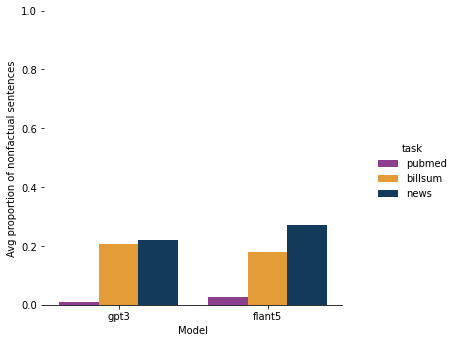

In [88]:
import seaborn as sns
# sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt





def aggregate_scores(df_errors_news, df_errors_billsum, df_errors_pubmed):
    
    df_all_errors = pd.concat([df_errors_news, df_errors_billsum, df_errors_pubmed])

    aggregate_score_df_dict = {'model': [], 'task': [], 'score': []}
    for task in list(set(df_all_errors['task'].values)):
        for model in list(set(df_all_errors['model'].values)):
            df_task_model = df_all_errors[(df_all_errors['task'] == task) & (df_all_errors['model'] == model)]
            score = np.mean(list(df_task_model['score'].values))
            aggregate_score_df_dict['model'].append(model)
            aggregate_score_df_dict['task'].append(task)
            aggregate_score_df_dict['score'].append(score)
    aggregate_score_df  = pd.DataFrame(aggregate_score_df_dict)     
    aggregate_score_df.sort_values(by=['score'], inplace=True)
    
    clrs = []
    task_color_map= {'pubmed': 'yellow',
                 'news': '#306844',
                 'billsum': 'black'}

    # print(aggregate_score_df)
    for task in aggregate_score_df['task'].values:
        clrs.append(task_color_map[task])
        
    
    plt.figure(figsize=(20,8))
    ax = sns.catplot(
        
        data=aggregate_score_df,
        kind="bar",
        x="model", y="score", hue="task",
         palette=sns.color_palette([  '#993299', '#ffa11c', '#073a67', ]),
        height= 4
         


    )
    ax.fig.set_size_inches(7, 5)
    sns.despine(bottom = False, left =True)
    # ax.spines['left'].set_color('orange')
    ax.set(ylim=(0, 1))
    ax.set(xlabel='Model', ylabel='Avg proportion of nonfactual sentences')
    plt.savefig('prev_errors.png')
aggregate_scores(df_errors_news, df_errors_billsum, df_errors_pubmed)

In [7]:
def plot_categories(df_aggrs, tasks):
    
    
    category_aggregate_scores = { 
                                 'intrinsic': [], 
                                 'extrinsic(factual)': [], 
                                 'extrinsic(factual_outdated)': [],
                                 'extrinsic(nonfactual)': [], 
                                 'mixed': [],
                                 
                            
                                }

    for df_aggr, task in list(zip(df_aggrs, tasks)):
        df_aggr_model = df_aggr[(~df_aggr['error_type_ann1'].isnull()) | (~df_aggr['error_type_ann2'].isnull())]
        error_categories = []
        for idx, row in df_aggr_model.iterrows():
            error_category_ann1 = row['error_type_ann1']
            error_category_ann2 = row['error_type_ann2']

            error_factuality_ann1 = row['error_factuality_ann1']
            error_factuality_ann2 = row['error_factuality_ann2']
    
            errors_found = [row['error_type_ann1'], row['error_type_ann2']]
            errors_found = [each for each in errors_found if each!= None and each != 'other']
            # print(errors_found)
            
            if len(list(set(errors_found))) > 1:
                error_categories.append('mixed')
                
            elif len(list(set(errors_found))) == 1:
                errors_mapped = []
                if error_category_ann1 != None and error_category_ann1 != 'other':
                    if error_factuality_ann1:
                        error_category_ann1 = f'{error_category_ann1}({error_factuality_ann1})'
                    errors_mapped.append(error_category_ann1)
                
                if error_category_ann2 != None and error_category_ann2 != 'other':
                    if error_factuality_ann2:
                        error_category_ann2 = f'{error_category_ann2}({error_factuality_ann2})'
                    errors_mapped.append(error_category_ann2)
                    
                
                error_categories += list(set(errors_mapped))
        
        print(set(error_categories) - set(category_aggregate_scores))
        for category in category_aggregate_scores:
            # print(category)
            score = error_categories.count(category)/len(error_categories)
            category_aggregate_scores[category].append(score)
        # models.append(task)
    category_aggregate_scores['tasks'] = tasks
    # category_aggregate_scores['model'] = df_aggr['system_id'].values
    # category_aggregate_scores.sort_values(by=['score'], inplace=True)
    # print(category_aggregate_scores)
    # category_aggregate_scores.sort_by()
    df_cat = pd.DataFrame(category_aggregate_scores, index=tasks)
    f = plt.figure(figsize=(7, 5))
    # f = plt.figure()
    ax = df_cat.plot(kind='bar', stacked=True,  color = ['#ffd966', '#eeb2d5', '#de66ac', '#c90076', '#ff7449'],  ax=f.gca(), width = 0.25)
    # sns.displot(df_cat, x = 'tasks', mult
    # plt.despine(left=True)
    ax.spines['bottom'].set_linewidth(0.5)  # change width
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.set(xlabel='Domain', ylabel='Ratio of errors')
    plt.savefig('error_categories.png', bbox_inches="tight")
    plt.show()
    

set()
set()
set()


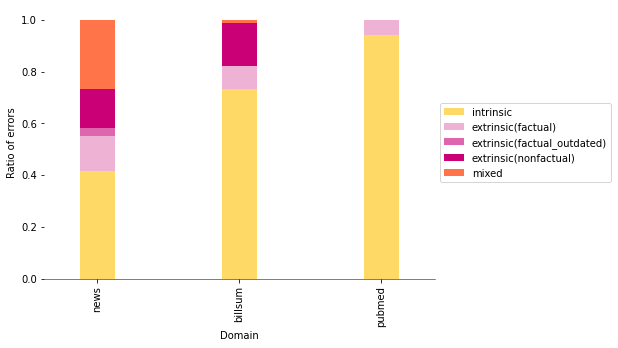

In [8]:
plot_categories([df_aggr_news, df_aggr_billsum, df_aggr_pubmed], ['news', 'billsum', 'pubmed' ])

In [45]:
from nltk import ngrams
from sklearn.metrics.pairwise import cosine_similarity
import math 
import numpy as np
from nltk.tokenize import sent_tokenize
from numpy.linalg import norm
# nlp = spacy.load('en_core_web_lg')
def copying(df_errors):
    ngram_overlap_scores = []
    for idx, row in df_errors.iterrows():
        article = row['article']
        summary = row['summary']
        article_3_grams = ngrams(article.split(), 4)
        article_3_grams = [each for each in article_3_grams]
        
        summary_3_grams = ngrams(summary.split(), 4)
        summary_3_grams = [each for each in summary_3_grams]
        
        n_grams_overlap = list(set(article_3_grams).intersection(set(summary_3_grams)))
        perc_overlap = len(n_grams_overlap)/ len(summary_3_grams)
        ngram_overlap_scores.append(perc_overlap)
        # doc_art = sent_tokenize(article)
        # doc_summ = sent_tokenize(summary)
        # summ_scores = []
        # for summ_sent in doc_summ:
        #     scores = []
        #     # print(summ_sent)
        #     summ_sent = nlp(summ_sent)
        #     summ_vect = summ_sent.vector
        #     for art_sent in doc_art:
        #         art_sent = nlp(art_sent)
        #         # scores.append(cosine_similarity())
        #         art_vect = art_sent.vector
        #         cosine = np.dot(summ_vect,art_vect)/(norm(summ_vect)*norm(art_vect))
        #         score = 0
        #         if cosine > 0.95:
        #             score = 1
        #         scores.append(score)
        #     summ_scores.append(max(scores))
            
        # ngram_overlap_scores.append(np.mean(summ_scores))
        
    df_errors['ngram_overlap'] = ngram_overlap_scores
    return df_errors

def get_copying_tendencies(df_errors, task):
    print(task.upper())
    print('FLANT5', np.mean(df_errors[df_errors['model'] == 'flant5']['ngram_overlap']))
    print('GPT3', np.mean(df_errors[df_errors['model'] == 'gpt3']['ngram_overlap']))
    print('**'*13)
# print('Average copying')     

NEWS CORRELATION
SignificanceResult(statistic=0.5689615778325463, pvalue=6.573128906448448e-10)
BILLSUM CORRELATION
SignificanceResult(statistic=0.36155294632610724, pvalue=0.00021909116122665202)
PUBMED CORRELATION
SignificanceResult(statistic=0.21948660082411628, pvalue=0.02822824497033457)


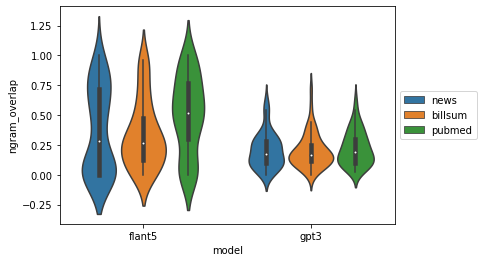

In [86]:
df_errors_news = copying(df_errors_news)
df_errors_billsum = copying(df_errors_billsum)
df_errors_pubmed = copying(df_errors_pubmed)

# get_copying_tendencies(df_errors_news, task = 'news')
# get_copying_tendencies(df_errors_billsum, task = 'billsum')
# get_copying_tendencies(df_errors_pubmed, task = 'pubmed')

df_all_errors = pd.concat([df_errors_news, df_errors_billsum, df_errors_pubmed])

print('NEWS CORRELATION')
fact_scores = [1 - each for each in df_errors_news['score']]
print(stats.spearmanr(fact_scores, df_errors_news['ngram_overlap']))

print('BILLSUM CORRELATION')
fact_scores = [1 - each for each in df_errors_billsum['score']]
print(stats.spearmanr(fact_scores, df_errors_billsum['ngram_overlap']))

print('PUBMED CORRELATION')
fact_scores = [1 - each for each in df_errors_pubmed['score']]
print(stats.spearmanr(fact_scores, df_errors_pubmed['ngram_overlap']))

sns.violinplot(data=df_all_errors, y="ngram_overlap", x = 'model', hue = 'task')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# ax.set(xlabel='Domain', ylabel='Ratio of errors')
plt.savefig('copying_models.png', bbox_inches="tight")
plt.show()

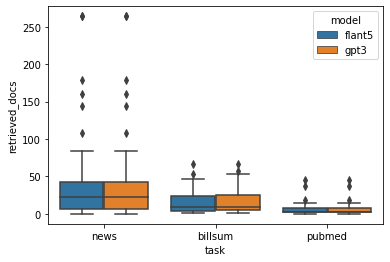

In [87]:
from query_news_config import news_query_map
from query_pubmed_config import pubmed_query_map
from query_billsum_config import billsum_query_map
def make_retrieved_docs_rows(df_all_errors):
    retrieved_docs = []
    for idx, row in df_all_errors.iterrows():
        uuid = row['summary_uuid']
        if uuid in news_query_map:
            retrieved_docs.append(news_query_map[uuid][1])
        elif uuid in pubmed_query_map:
            retrieved_docs.append(pubmed_query_map[uuid][1])
        elif uuid in billsum_query_map:
            retrieved_docs.append(billsum_query_map[uuid][1])
        else:
            retrieved_docs.append(None)
    df_all_errors['retrieved_docs'] = retrieved_docs
    return df_all_errors

df_all_errors = make_retrieved_docs_rows( df_all_errors)
df_all_errors_retr = df_all_errors[~df_all_errors['retrieved_docs'].isnull()]
ax = sns.boxplot(data=df_all_errors_retr, y="retrieved_docs", x="task",  hue="model")

In [18]:
from QAFactEval.qafacteval import QAFactEval
from questeval.questeval_metric import QuestEval
# from summac.model_summac import SummaCZS, SummaCConv

def get_questeval_score(articles, summaries):
    questeval = QuestEval(no_cuda=False)
    score = questeval.corpus_questeval(
    hypothesis=summaries, 
    sources=articles
    )
    return score['ex_level_scores']

def get_summac_score(articles, summaries):
    device = 'cuda'
    model_zs = SummaCZS(granularity="sentence", model_name="vitc", device=device) # If you have a GPU: switch to: device="cuda"
    model_conv = SummaCConv(models=["vitc"], bins='percentile', granularity="sentence", nli_labels="e", device=device, start_file="default", agg="mean")
    score_zs1 = model_zs.score(articles, summaries)
    score_conv1 = model_conv.score(articles, summaries)
    return score_zs1['scores'], score_conv1['scores']

def get_qafacteval_score(articles, summaries):
    kwargs = {"cuda_device": 0, "use_lerc_quip": True, \
        "verbose": True, "generation_batch_size": 32, \
        "answering_batch_size": 32, "lerc_batch_size": 8}

    model_folder = "/home/ramprasad.sa/factual_annotation_llm_summaries/analysis/notebook/QAFactEval/models" # path to models downloaded with download_models.sh
    metric = QAFactEval(
        lerc_quip_path=f"{model_folder}/quip-512-mocha",
        generation_model_path=f"{model_folder}/generation/model.tar.gz",
        answering_model_dir=f"{model_folder}/answering",
        lerc_model_path=f"{model_folder}/lerc/model.tar.gz",
        lerc_pretrained_model_path=f"{model_folder}/lerc/pretraining.tar.gz",
        **kwargs
    )
    qafacteval_scores = []
    docs = []
    summs = []
    for art, summ in list(zip(articles, summaries)):
        docs.append(art)
        summs.append([summ])
    results = metric.score_batch_qafacteval(docs, summs, return_qa_pairs=True)
    # results = metric.score_batch_qafacteval([art], [[summ]], return_qa_pairs=True)
    # score = results[0][0]['qa-eval']['lerc_quip']
    # qafacteval_scores.append(score)
    return results


In [152]:
from scipy import stats

def make_summac(df_errors):
    summaczs, summacc = get_summac_score(list(df_errors['article'].values), list(df_errors['summary'].values))
    df_errors['SummaC_Conv'] = summacc
    df_errors['SummaC_ZS'] = summaczs
    y_scores = [1 - each for each in df_errors['score']]
    print(stats.spearmanr(summaczs, y_scores), stats.spearmanr(summacc, y_scores))
    print(stats.pearsonr(summaczs, y_scores), stats.pearsonr(summacc, y_scores))
    return df_errors

def make_questeval(df_errors):
    questeval_score = get_questeval_score(list(df_errors['article'].values), list(df_errors['summary'].values))
    df_errors['QuestEval'] = questeval_score
    y_scores = [1 - each for each in df_errors['score']]
    print(stats.spearmanr(questeval_score, y_scores))
    print(stats.pearsonr(questeval_score, y_scores))
    return df_errors

def make_qafacteval(df_errors):
    qafacteval_scores = get_qafacteval_score(list(df_errors_news['article'].values), list(df_errors_news['summary'].values))
    df_errors['QAFactEval'] = qafacteval_score
    y_scores = [1 - each for each in df_errors['score']]
    print(stats.spearmanr(qafacteval_score, y_scores))
    print(stats.pearsonr(qafacteval_score, y_scores))
    return df_errors

In [49]:
scores = get_qafacteval_score(list(df_errors_news[:2]['article'].values), list(df_errors_news[:2]['summary'].values))



Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['final_logits_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at /home/ramprasad.sa/factual_annotation_llm_summaries/analysis/notebook/QAFactEval/models/quip-512-mocha were not used when initializing RobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClas

In [55]:
# scores[0][0]

{'qa-eval': {'f1': 0.13333333333333333,
  'lerc_quip': 0.5820512771606445,
  'em': 0.0,
  'is_answered': 0.2}}

In [25]:
df_errors_billsum = make_questeval(df_errors_billsum)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SignificanceResult(statistic=0.07186655922843786, pvalue=0.4773633149301387)
PearsonRResult(statistic=0.1929546352832219, pvalue=0.054429393339134706)


In [26]:
df_errors_pubmed = make_questeval(df_errors_pubmed)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SignificanceResult(statistic=0.02412557173103034, pvalue=0.8116816118695738)
PearsonRResult(statistic=0.06305565762390722, pvalue=0.5331205205861819)


In [61]:
with open('uuid_doc_map.json', 'r') as fp:
    uuid_doc_map = json.load( fp)

In [64]:
training_docs = []
for idx, row in df_all_errors.iterrows():
    uuid = row['summary_uuid']
    if uuid in uuid_doc_map:
        training_docs.append(uuid_doc_map[uuid])
# df_all_errors['generated_doc'] = training_docs
training_docs

['The bill aims to discourage States and local governments from offering general welfare assistance to able-bodied people who are not involved in workfare programs. It proposes that such individuals must participate in work-related activities, such as job training or community service, in order to receive welfare benefits. The purpose of the bill is to encourage self-sufficiency and greater independence amongst welfare recipients, reduce the burden on taxpayers, and improve the economy.',
 'The Responsible Deficit Reduction Act of 1995 was a bill proposed by Republicans in the United States Congress. The bill aimed to reduce the federal deficit by cutting government spending and restructuring entitlement programs. Some of the proposed cuts included reductions in welfare, foreign aid, and funding for the arts. The bill also sought to balance the budget by 2002. The legislation faced opposition from Democrats who argued that cuts in social programs would disproportionately hurt low-incom